# Essay Writer
https://github.com/kyopark2014/langgraph-agent/blob/main/essay-writer.md



In [2]:
import boto3

In [3]:
!pip3 install langchain-aws langchain-community langchain --quiet

In [4]:
from botocore.config import Config
from langchain_aws import ChatBedrock
bedrock_region = 'us-east-1'
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=bedrock_region,
    config=Config(
        retries = {
            'max_attempts': 30
        }            
    )
)

HUMAN_PROMPT = "\n\nHuman:"
AI_PROMPT = "\n\nAssistant:"
maxOutputTokens = 4096
parameters = {
    "max_tokens":maxOutputTokens,     
    "temperature":0.1,
    "top_k":250,
    "top_p":0.9,
    "stop_sequences": [HUMAN_PROMPT]
}    
chat = ChatBedrock(   
    model_id=modelId,
    client=boto3_bedrock, 
    model_kwargs=parameters,
)

In [5]:
from langchain.memory import ConversationBufferWindowMemory
memory_chain = ConversationBufferWindowMemory(memory_key="chat_history", output_key='answer', return_messages=True, k=10)

## Tavily Search

In [6]:
import getpass

api_key = getpass.getpass("Password:")

Password: ········


In [7]:
import os
os.environ["TAVILY_API_KEY"] = api_key

In [8]:
!pip install -U langchain-community tavily-python --quiet

In [9]:
langsmith_api_key = getpass.getpass("Password:")

Password: ········


In [10]:
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Plan-and-execute"

In [11]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
            "다음의 Human과 Assistant의 친근한 이전 대화입니다."
            "Assistant은 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다."
            "Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
chain = prompt | chat

msg = ""
request = HumanMessage(
    content="2023년 프로야구 우승팀은 누구인가요?"
)

output = chain.stream({"messages": [request]})
for event in output:
    print(event.content, end="")
    msg += event.content
    
msg

안녕하세요 서연이에요. 2023년 프로야구 시즌이 아직 진행 중이라 우승팀을 정확히 알려드리기는 어렵네요. 하지만 현재 정규시즌 순위와 각 팀의 전력을 바탕으로 우승 후보팀들을 말씀드릴 수 있어요. 정규시즌 잔여 경기와 가을 야구를 통해 최종 우승팀이 가려질 것입니다. 구체적인 정보가 필요하시다면 언제든 물어봐 주세요.

'안녕하세요 서연이에요. 2023년 프로야구 시즌이 아직 진행 중이라 우승팀을 정확히 알려드리기는 어렵네요. 하지만 현재 정규시즌 순위와 각 팀의 전력을 바탕으로 우승 후보팀들을 말씀드릴 수 있어요. 정규시즌 잔여 경기와 가을 야구를 통해 최종 우승팀이 가려질 것입니다. 구체적인 정보가 필요하시다면 언제든 물어봐 주세요.'

In [12]:
import operator
from typing import Annotated, List, Tuple, TypedDict
from langgraph.graph.message import add_messages
from typing import Annotated, List, Tuple, TypedDict, Literal, Sequence, Union

In [13]:
from langchain_core.pydantic_v1 import BaseModel, Field


In [14]:
selected_chat = 0
LLM_for_chat = [
  {
    "bedrock_region": "us-west-2", # Oregon
    "model_type": "claude3",
    "model_id": "anthropic.claude-3-sonnet-20240229-v1:0"
  }
]

In [15]:
def get_chat():
    global selected_chat
    
    profile = LLM_for_chat[selected_chat]
    bedrock_region =  profile['bedrock_region']
    modelId = profile['model_id']
    print(f'selected_chat: {selected_chat}, bedrock_region: {bedrock_region}, modelId: {modelId}')
                          
    # bedrock   
    boto3_bedrock = boto3.client(
        service_name='bedrock-runtime',
        region_name=bedrock_region,
        config=Config(
            retries = {
                'max_attempts': 30
            }
        )
    )
    parameters = {
        "max_tokens":maxOutputTokens,     
        "temperature":0.1,
        "top_k":250,
        "top_p":0.9,
        "stop_sequences": [HUMAN_PROMPT]
    }
    # print('parameters: ', parameters)

    chat = ChatBedrock(   # new chat model
        model_id=modelId,
        client=boto3_bedrock, 
        model_kwargs=parameters,
    )    
    
    selected_chat = selected_chat + 1
    if selected_chat == len(LLM_for_chat):
        selected_chat = 0
    
    return chat

In [16]:
class State(TypedDict):
    task: str
    plan: list[str]
    essay: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

class Plan(BaseModel):
    """List of session topics and outline as a json format"""

    steps: List[str] = Field(
        description="different sessions to follow, should be in sorted order without numbers. Eash session has detailed description"
    )
    

## Plan

In [17]:
def get_planner():
    system = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections. \
Make sure that each session has all the information needed."""
    
    #system = """You are an expert writer tasked with writing a high level outline of an essay.\
#For the given objective, come up with a simple step by step plan. \
#This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
#The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps."""
            
    planner_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("placeholder", "{messages}"),
        ]
    )
        
    chat = get_chat()   
        
    planner = planner_prompt | chat
    return planner

In [18]:
def plan(state: State):
    print("###### plan ######")
    print('task: ', state["task"])
        
    task = [HumanMessage(content=state["task"])]

    planner = get_planner()
    response = planner.invoke({"messages": task})
    print('response.content: ', response.content)
        
    chat = get_chat()
    structured_llm = chat.with_structured_output(Plan, include_raw=True)
    info = structured_llm.invoke(response.content)
    print('info: ', info)
        
    if not info['parsed'] == None:
        parsed_info = info['parsed']
        # print('parsed_info: ', parsed_info)        
        print('steps: ', parsed_info.steps)
            
        return {
            "task": state["task"],
            "plan": parsed_info.steps
        }
    else:
        print('parsing_error: ', info['parsing_error'])
            
        return {"plan": []}  

In [34]:
result_plan = plan({"task":"즐겁게 사는 방법"})

###### plan ######
task:  즐겁게 사는 방법
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
response.content:  여기 즐겁게 사는 방법에 대한 에세이 개요가 있습니다:

I. 서론
   - 행복의 정의와 중요성에 대해 간략히 설명
   - 주제 제시: 즐겁게 살기 위한 방법들

II. 긍정적인 마음가짐 유지하기
   - 부정적인 생각을 긍정적으로 전환하는 방법
   - 감사하는 습관 기르기
   - 낙관주의와 희망적 사고의 중요성

III. 균형 잡힌 생활 영위하기  
   - 일과 휴식의 균형 유지
   - 운동과 건강한 식습관의 중요성
   - 취미 생활과 여가 활동의 역할

IV. 인간관계 소중히 여기기
   - 가족, 친구, 동료들과의 관계 돈독히 하기
   - 타인을 배려하고 이해하는 자세 기르기
   - 사회적 유대감 형성의 중요성

V. 자기계발과 성장 추구하기
   - 새로운 것을 배우고 도전하는 자세
   - 장기적인 목표 설정과 성취를 향한 노력
   - 영적, 정신적 성장의 가치

VI. 결론
   - 주요 내용 요약 
   - 즐거운 삶을 위한 통합적 접근의 필요성 강조
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
info:  {'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 821, 'completion_tokens': 384, 'total_tokens': 1205}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_

In [35]:
result_plan

{'task': '즐겁게 사는 방법',
 'plan': ['행복의 정의와 중요성에 대한 간략한 설명과 주제 제시',
  '긍정적인 마음가짐을 유지하기 위한 방법들 - 부정적 생각을 긍정적으로 전환, 감사하는 습관, 낙관주의와 희망적 사고의 중요성',
  '균형 잡힌 생활을 영위하기 위한 방법들 - 일과 휴식의 균형, 운동과 건강한 식습관, 취미생활과 여가활동',
  '인간관계를 소중히 여기는 방법들 - 가족/친구/동료와의 관계 돈독히 하기, 타인 배려와 이해, 사회적 유대감 형성',
  '자기계발과 성장을 추구하는 방법들 - 새로운 것 배우기와 도전, 장기 목표 설정과 성취 노력, 영적/정신적 성장의 가치',
  '주요 내용 요약 및 즐거운 삶을 위한 통합적 접근의 필요성 강조']}

In [36]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [37]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [38]:
def research_plan(state: State):
    task = state['task']
    print('task: ', task)
    
    system = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""
        
    research_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{task}"),
        ]
    )
        
    chat = get_chat()   
        
    research = research_prompt | chat
    
    response = research.invoke({"task": task})
    print('response.content: ', response.content)
    
    chat = get_chat()
    structured_llm = chat.with_structured_output(Queries, include_raw=True)
    info = structured_llm.invoke(response.content)
    # print('info: ', info)
    
    if not info['parsed'] == None:
        queries = info['parsed']
        print('queries: ', queries.queries)
        
    content = state["content"] if state.get("content") is not None else []
    search = TavilySearchResults(k=2)
    for q in queries.queries:
        response = search.invoke(q)     
        # print('response: ', response)        
        for r in response:
            content.append(r['content'])
    return {        
        "task": state['task'],
        "plan": state['plan'],
        "content": content,
    }

In [39]:
output_research = research_plan(result_plan)

task:  즐겁게 사는 방법
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
response.content:  여기 "즐겁게 사는 방법"에 대한 정보를 찾기 위한 검색어 제안입니다:

1. 행복한 삶의 방법
2. 긍정적 마인드 기르기
3. 일상에서 행복 찾기 팁

이 검색어들을 통해 행복한 삶을 위한 구체적인 조언과 실천 방법, 긍정적인 마인드를 기르는 방법, 일상 속 작은 행복을 발견하는 방법 등의 정보를 찾을 수 있을 것입니다. 삶의 질을 높이고 행복해지기 위한 다양한 관점과 전략을 제공할 것으로 기대됩니다.
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
queries:  ['행복한 삶의 방법', '긍정적 마인드 기르기', '일상에서 행복 찾기 팁']


In [40]:
print('output: ', output_research)

output:  {'task': '즐겁게 사는 방법', 'plan': ['행복의 정의와 중요성에 대한 간략한 설명과 주제 제시', '긍정적인 마음가짐을 유지하기 위한 방법들 - 부정적 생각을 긍정적으로 전환, 감사하는 습관, 낙관주의와 희망적 사고의 중요성', '균형 잡힌 생활을 영위하기 위한 방법들 - 일과 휴식의 균형, 운동과 건강한 식습관, 취미생활과 여가활동', '인간관계를 소중히 여기는 방법들 - 가족/친구/동료와의 관계 돈독히 하기, 타인 배려와 이해, 사회적 유대감 형성', '자기계발과 성장을 추구하는 방법들 - 새로운 것 배우기와 도전, 장기 목표 설정과 성취 노력, 영적/정신적 성장의 가치', '주요 내용 요약 및 즐거운 삶을 위한 통합적 접근의 필요성 강조'], 'content': ['이 글에서는 행복한 삶을 살기 위한 다양한 방법 10가지와 주의 사항에 대해 알아보겠습니다. 행복하게 사는 방법 10가지 1. 자기 자신을 이해하고 수용하기 행복한 삶의 첫 번째 단계는 자기 자신을 이해하고 받아들이는 것입니다. 자신의 강점과 약점을 알고 ...', '다만 그것을 실행하지 못하고 살아갈 뿐. 그것이 삶의 아이러니입니다. 행복도 행복 나름입니다. ... 그런 것들이 행복한 삶을 살게 하는 에너지의 원천이 됩니다. ... 아주 어려운 일도 아닙니다. <삶이 행복해지는 9가지 방법>을 실천하며 살아보세요. 바로 그렇게 ...', '행복한 삶을 사는 법. 누구나 행복한 삶을 살고 싶어 한다. 사람들은 각자 성공을 다르게 정의하거나 다른 기준을 가지고 행복도를 측정하지만, 그래도 일반적으로 행복하다고 생각되는 삶의 기본적인 요소들이 존재하는 것은 사실이다. 연구에 의하면 삶의 어느 지점에서 시작하던, 성인이 되고 ...', '행복한 삶이란 도대체 무엇인가? ... 꾸준히 의욕을 내는 좋은 방법 중 하나는 진행 상황을 기록하고 꾸준히 확인하는 것이다. 목표와 개인적인 선호도에 따라 앱, 플래너, 달력 등을 쓸 수 있다. ... 사람들이 삶의 의미와 목적을 

### Generate

In [41]:
def generation(state: State):    
    print('content: ', state['content'])
    print('task: ', state['task'])
    print('plan: ', state['plan'])
                          
    content = "\n\n".join(state['content'] or [])
    
#    system = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
#Generate the best essay possible for the user's request and the initial outline. \
#If the user provides critique, respond with a revised version of your previous attempts. \
#Utilize all the information below as needed: """
#    system = """당신은 5문단의 에세이 작성을 돕는 작가입니다. \
#용자의 요청에 대해 최고의 에세이를 작성하세요. \
#사용자가 에세이에 대해 평가를 하면, 이전 에세이를 수정하여 답변하세요. \
#최종 답변에는 완성된 에세이 전체 내용을 반드시 포함하여야 하고, <result> tag를 붙여주세요."""
    system = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

<content>
{content}
</content>
"""
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{task}\n\nHere is my plan:\n\n{plan}"),
        ]
    )
        
    chat = get_chat()
    chain = prompt | chat

    response = chain.invoke({
        "content": content,
        "task": state['task'],
        "plan": state['plan']
    })
    # print('response: ', response)
        
    revision_number = state["revision_number"] if state.get("revision_number") is not None else 1
    return {
        "essay": response, 
        "revision_number": revision_number + 1
    }

In [42]:
result_generation = generation(output_research)

content:  ['이 글에서는 행복한 삶을 살기 위한 다양한 방법 10가지와 주의 사항에 대해 알아보겠습니다. 행복하게 사는 방법 10가지 1. 자기 자신을 이해하고 수용하기 행복한 삶의 첫 번째 단계는 자기 자신을 이해하고 받아들이는 것입니다. 자신의 강점과 약점을 알고 ...', '다만 그것을 실행하지 못하고 살아갈 뿐. 그것이 삶의 아이러니입니다. 행복도 행복 나름입니다. ... 그런 것들이 행복한 삶을 살게 하는 에너지의 원천이 됩니다. ... 아주 어려운 일도 아닙니다. <삶이 행복해지는 9가지 방법>을 실천하며 살아보세요. 바로 그렇게 ...', '행복한 삶을 사는 법. 누구나 행복한 삶을 살고 싶어 한다. 사람들은 각자 성공을 다르게 정의하거나 다른 기준을 가지고 행복도를 측정하지만, 그래도 일반적으로 행복하다고 생각되는 삶의 기본적인 요소들이 존재하는 것은 사실이다. 연구에 의하면 삶의 어느 지점에서 시작하던, 성인이 되고 ...', '행복한 삶이란 도대체 무엇인가? ... 꾸준히 의욕을 내는 좋은 방법 중 하나는 진행 상황을 기록하고 꾸준히 확인하는 것이다. 목표와 개인적인 선호도에 따라 앱, 플래너, 달력 등을 쓸 수 있다. ... 사람들이 삶의 의미와 목적을 찾고, 웰빙/성취감을 증진시킬 수 ...', '행복한 삶을 위한 7가지 조건. 1. 사랑하는 사람. 남편을 만나고, 사랑을 받고, 사랑을 주고, 위로와 격려를 받고 또 주다 보니 제 마음이 뭔가 더 따뜻해졌습니다. 그리고 마음이 따뜻해지다 보니 인생이 좀 더 행복하다고 느껴지더라고요. 사랑하는 사람과 ...', '개인적 발전, 긍정적 사고, 동기 부여, 마인드셋, 목표 설정, 성공 전략, 성장 마인드셋, 성취감, 실패에서 배우기, 창의성. 1. 긍정적 사고의 습관 기르기 우리 삶에서 마주치는 수많은 도전들은 종종 우리를 좌절시키기도 합니다. 하지만 중요한 것은 이러한 ...', '긍정적인 마인드가 왜 중요할까요? 뇌과학에서는 긍정적인 마인드가 실제 우리 뇌에 좋은 힘을 줄 수 있다고

In [43]:
result_generation

{'essay': AIMessage(content='행복한 삶을 살기 위한 길잡이\n\n모두가 행복한 삶을 꿈꾸지만 실제로 행복을 느끼는 것은 쉽지 않습니다. 행복은 단순히 물질적 풍요나 일시적인 기쁨을 넘어서는 삶의 만족과 충만함을 의미합니다. 진정한 행복을 위해서는 우리의 마음가짐과 생활 방식에 주목해야 합니다.\n\n첫째, 긍정적인 마음가짐을 기르는 것이 중요합니다. 부정적인 생각과 감정에 사로잡히기보다는 낙관적이고 희망적인 관점을 가져야 합니다. 작은 일상의 기쁨에 감사하는 습관을 들이고, 어려운 상황에서도 긍정적인 면을 찾아보세요. \n\n둘째, 균형 잡힌 생활 리듬을 유지하는 것이 행복의 열쇠입니다. 일과 휴식의 적절한 조화를 이루고, 운동과 건강한 식습관으로 몸과 마음의 건강을 돌보세요. 또한 취미생활이나 여가활동을 통해 재미와 활력을 얻을 수 있습니다.\n\n셋째, 인간관계를 소중히 여기는 자세가 필요합니다. 가족, 친구, 동료들과 정서적 유대를 돈독히 하고 서로를 이해하고 배려하는 마음을 가져야 합니다. 타인과의 유대감은 행복감을 높이는 원천이 됩니다.\n\n넷째, 자기계발과 성장의 기회를 놓치지 마세요. 새로운 것을 배우고 도전하며 장기적인 목표를 향해 나아가는 과정에서 성취감과 보람을 느낄 수 있습니다. 영적, 정신적 성장 또한 행복에 이르는 중요한 길잡이가 될 것입니다.\n\n마지막으로 행복은 이 모든 요소들이 조화를 이룰 때 비로소 가능해집니다. 긍정적 마음가짐, 균형 잡힌 생활, 인간관계, 자기계발을 통합적으로 추구할 때 진정한 행복이 우리 곁에 머물 것입니다. 오늘부터 작은 실천으로 행복한 삶의 여정을 시작해보세요.', additional_kwargs={'usage': {'prompt_tokens': 2806, 'completion_tokens': 826, 'total_tokens': 3632}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1

In [44]:
result_generation['essay'].content

'행복한 삶을 살기 위한 길잡이\n\n모두가 행복한 삶을 꿈꾸지만 실제로 행복을 느끼는 것은 쉽지 않습니다. 행복은 단순히 물질적 풍요나 일시적인 기쁨을 넘어서는 삶의 만족과 충만함을 의미합니다. 진정한 행복을 위해서는 우리의 마음가짐과 생활 방식에 주목해야 합니다.\n\n첫째, 긍정적인 마음가짐을 기르는 것이 중요합니다. 부정적인 생각과 감정에 사로잡히기보다는 낙관적이고 희망적인 관점을 가져야 합니다. 작은 일상의 기쁨에 감사하는 습관을 들이고, 어려운 상황에서도 긍정적인 면을 찾아보세요. \n\n둘째, 균형 잡힌 생활 리듬을 유지하는 것이 행복의 열쇠입니다. 일과 휴식의 적절한 조화를 이루고, 운동과 건강한 식습관으로 몸과 마음의 건강을 돌보세요. 또한 취미생활이나 여가활동을 통해 재미와 활력을 얻을 수 있습니다.\n\n셋째, 인간관계를 소중히 여기는 자세가 필요합니다. 가족, 친구, 동료들과 정서적 유대를 돈독히 하고 서로를 이해하고 배려하는 마음을 가져야 합니다. 타인과의 유대감은 행복감을 높이는 원천이 됩니다.\n\n넷째, 자기계발과 성장의 기회를 놓치지 마세요. 새로운 것을 배우고 도전하며 장기적인 목표를 향해 나아가는 과정에서 성취감과 보람을 느낄 수 있습니다. 영적, 정신적 성장 또한 행복에 이르는 중요한 길잡이가 될 것입니다.\n\n마지막으로 행복은 이 모든 요소들이 조화를 이룰 때 비로소 가능해집니다. 긍정적 마음가짐, 균형 잡힌 생활, 인간관계, 자기계발을 통합적으로 추구할 때 진정한 행복이 우리 곁에 머물 것입니다. 오늘부터 작은 실천으로 행복한 삶의 여정을 시작해보세요.'

### Reflection

In [47]:
def reflection(state: State):    
    """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

    reflection_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "당신은 교사로서 학셍의 에세이를 평가하삽니다. 비평과 개선사항을 친절하게 설명해주세요."
                "이때 장점, 단점, 길이, 깊이, 스타일등에 대해 충분한 정보를 제공합니다."
                #"특히 주제에 맞는 적절한 예제가 잘 반영되어있는지 확인합니다"
                "각 문단의 길이는 최소 200자 이상이 되도록 관련된 예제를 충분히 포함합니다.",
            ),
            ("human", "{essay}"),
        ]
    )
    
    chat = get_chat()
    reflect = reflection_prompt | chat
            
    res = reflect.invoke({"essay": state['essay'].content})    
    response = HumanMessage(content=res.content)    
    
    return {
        "critique": response,
        "revision_number": int(state['revision_number'])
    }

In [48]:
output_reflection = reflection(result_generation)

selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0


In [49]:
output_reflection['critique'].content

'전반적으로 행복한 삶을 살기 위한 좋은 지침들을 제시하고 있습니다. 다음은 몇 가지 장점과 개선 사항에 대한 피드백입니다.\n\n장점:\n\n1. 행복의 의미를 잘 정의하고, 물질적 풍요나 일시적 기쁨을 넘어서는 삶의 만족과 충만함이라고 설명한 점이 좋습니다.\n\n2. 행복을 위한 구체적인 요소들(긍정적 마음가짐, 균형 잡힌 생활, 인간관계, 자기계발)을 잘 제시하고 있습니다. \n\n3. 각 요소에 대해 구체적인 실천 방안을 제안하고 있어 실용적입니다. 예를 들어 "작은 일상의 기쁨에 감사하는 습관"이나 "운동과 건강한 식습관"과 같은 구체적인 방법들을 언급하고 있습니다.\n\n4. 마지막 부분에서 행복의 요소들이 조화를 이루어야 함을 강조하고 있어 균형 잡힌 관점을 제시하고 있습니다.\n\n개선 사항:\n\n1. 각 문단의 길이가 다소 짧은 편입니다. 각 요소에 대해 좀 더 구체적인 예시나 설명을 추가하면 이해도를 높일 수 있을 것입니다.\n\n2. 긍정적 마음가짐을 기르는 구체적인 방법(예: 명상, 긍정적 자기 대화 등)에 대한 설명이 부족합니다.\n\n3. 인간관계 부분에서 가족, 친구 외에도 지역사회나 사회적 유대감의 중요성에 대해 언급할 수 있습니다.\n\n4. 자기계발과 성장의 구체적인 방법(예: 새로운 기술 배우기, 자원봉사 등)에 대한 설명이 부족합니다.\n\n5. 행복을 방해하는 요인들(예: 스트레스, 부정적 습관 등)에 대한 언급과 이를 극복하는 방법에 대한 조언이 추가되면 좋을 것 같습니다.\n\n전반적으로 행복한 삶을 위한 좋은 지침을 제시하고 있지만, 각 요소에 대한 구체적인 예시와 설명을 보완하고 균형 잡힌 관점을 더 강조한다면 더욱 도움이 될 것입니다.'

In [50]:
def research_critique(state: State):
    system = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""
    
    critique_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{critique}"),
        ]
    )
    
    chat = get_chat()           
    critique = critique_prompt | chat    
    response = critique.invoke({"critique": state['critique']})
    print('response.content: ', response.content)
    
    chat = get_chat()
    structured_llm = chat.with_structured_output(Queries, include_raw=True)
    info = structured_llm.invoke(response.content)
    # print('info: ', info)
    
    content = ""
    if not info['parsed'] == None:
        queries = info['parsed']
        print('queries: ', queries.queries)
        
        content = state["content"] if state.get("content") is not None else []
        search = TavilySearchResults(k=2)
        for q in queries.queries:
            response = search.invoke(q)     
            # print('response: ', response)        
            for r in response:
                content.append(r['content'])
    return {
        "content": content,
        "revision_number": int(state['revision_number'])
    }
    

In [51]:
result_critique = research_critique(output_reflection)

selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
response.content:  1. "행복한 삶을 위한 구체적인 실천 방안" 
2. "긍정적 마음가짐 기르기 위한 명상과 자기대화 기법"
3. "지역사회 및 사회적 유대감 강화를 통한 인간관계 개선 방법"
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
queries:  ['행복한 삶을 위한 구체적인 실천 방안', '긍정적 마음가짐 기르기 위한 명상과 자기대화 기법', '지역사회 및 사회적 유대감 강화를 통한 인간관계 개선 방법']


In [52]:
MAX_REVISIONS = 2
config = {"recursion_limit": 50}

In [53]:
def should_continue(state, config):
    max_revisions = config.get("configurable", {}).get("max_revisions", MAX_REVISIONS)
    print("max_revisions: ", max_revisions)
        
    if state["revision_number"] > max_revisions:
        return "end"
    return "contine"

In [54]:
should_continue(result, config)

max_revisions:  2


'contine'

## Create the Graph

In [55]:
from langgraph.graph import START, END, StateGraph

In [56]:
workflow = StateGraph(State)

workflow.add_node("planner", plan)
workflow.add_node("generation", generation)
workflow.add_node("reflection", reflection)
workflow.add_node("research_plan", research_plan)
workflow.add_node("research_critique", research_critique)

workflow.set_entry_point("planner")

workflow.add_conditional_edges(
    "generation", 
    should_continue, 
    {
        "end": END, 
        "contine": "reflection"}
)

workflow.add_edge("planner", "research_plan")
workflow.add_edge("research_plan", "generation")

workflow.add_edge("reflection", "research_critique")
workflow.add_edge("research_critique", "generation")

# graph = builder.compile(checkpointer=memory)

In [57]:
app = workflow.compile()

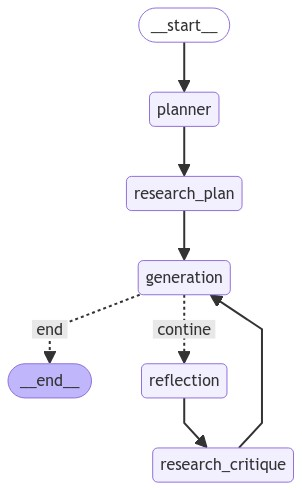

In [58]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## RUN

In [59]:
inputs = {"task": "즐겁게 사는 방법"}
config = {
    "recursion_limit": 50,
    "max_revisions": 2,
}
for output in app.stream(inputs, config=config):
    for key, value in output.items():
        print(f"Finished: {key}")

print("Final: ", value["essay"])

###### plan ######
task:  즐겁게 사는 방법
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
response.content:  여기 즐겁게 사는 방법에 대한 에세이 개요가 있습니다:

I. 서론
   - 행복의 정의와 중요성에 대해 간략히 설명
   - 주제 제시: 즐겁게 살기 위한 방법들

II. 긍정적인 마음가짐 유지하기
   - 부정적인 생각을 긍정적으로 전환하는 방법
   - 감사하는 습관 기르기
   - 유머 감각 기르기

III. 균형 잡힌 생활 영위하기  
   - 일과 휴식의 균형 유지
   - 운동과 건강한 식습관 실천
   - 충분한 수면 취하기

IV. 의미 있는 관계 맺기
   - 가족, 친구와의 관계 소중히 여기기
   - 새로운 사람들과 교류하기
   - 봉사활동을 통해 타인과 연결되기

V. 열정과 취미생활 가지기
   - 직업에서 열정을 찾거나 새로운 취미 활동 시작하기
   - 새로운 것을 배우고 도전하는 자세 갖기
   - 여가 시간을 즐기는 법 배우기

VI. 결론
   - 주요 내용 요약
   - 행복은 과정이며 지속적인 노력이 필요함을 강조
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
info:  {'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 806, 'completion_tokens': 514, 'total_tokens': 1320}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 806, 'c

In [60]:
value['essay'].content

'행복은 모든 사람들이 궁극적으로 추구하는 목표입니다. 하지만 행복의 정의와 그것을 성취하는 방법은 개인마다 다릅니다. 이 에세이에서는 일상생활에서 행복을 찾고 즐겁게 살아가는 방법에 대해 탐구해보겠습니다.\n\n첫째, 긍정적인 마음가짐을 유지하는 것이 중요합니다. 부정적인 생각은 우리의 기분과 삶의 질을 저하시킵니다. 그러므로 부정적인 생각을 긍정적으로 전환하려 노력해야 합니다. 또한 매일 감사한 일들을 떠올리고 유머 감각을 기르는 것도 도움이 됩니다.\n\n둘째, 균형 잡힌 생활 방식을 유지해야 합니다. 일과 휴식의 균형을 잡고, 규칙적인 운동과 건강한 식습관을 실천하며, 충분한 수면을 취하는 것이 중요합니다. 이를 통해 신체적, 정신적 건강을 유지할 수 있습니다.\n\n셋째, 의미 있는 관계를 맺는 것이 행복에 필수적입니다. 가족과 친구들과의 관계를 소중히 여기고, 새로운 사람들과 교류하며, 봉사활동을 통해 타인과 연결되는 것이 좋습니다. \n\n넷째, 열정과 취미생활을 가지는 것이 즐거운 삶을 위해 필요합니다. 직업에서 열정을 찾거나 새로운 취미활동을 시작하고, 새로운 것을 배우고 도전하는 자세를 갖추며, 여가시간을 즐기는 법을 배우는 것이 좋습니다.\n\n요약하자면, 긍정적 마인드, 균형 잡힌 생활, 의미 있는 관계, 열정과 취미생활이 행복한 삶을 위한 핵심 요소입니다. 행복은 한순간에 이루어지는 것이 아니라 지속적인 노력과 실천이 필요한 과정입니다. 이 방법들을 실천하며 매일 조금씩 행복에 다가가는 것이 중요합니다.'